The following code is almost entierly from adityzjin's kernel (https://www.kaggle.com/adityajn105/getting-started-with-vggface-0-787-lb)
The only addition are annotations or vizualisation steps helping understanding each step for beginners. Being a junior myself, I had to check the documentation numerous times. So please excuse my potential mistakes and don't hesitate to tell me if you spot one.

In [1]:
#Importing the Keras implementation of the VGGface pre-trained model of face recognition
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-68hrctlt
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-68hrctlt
  Stored in directory: /tmp/pip-ephem-wheel-cache-87pu1mps/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [2]:
import gc
import cv2
import glob
from keras_vggface.utils import preprocess_input

def read_img(path):
    """
    Function:
    ---------
    Turns an image into an array
    
    Input:
    ------
    path = path of the image file
    
    Returns:
    --------
    An array containing floats
    """
    
    img = cv2.imread(path)
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

Using TensorFlow backend.


In [3]:
from collections import defaultdict
#Oppositely to a 'normal' dic() function, defaultdict doesn't return an error when trying to access an item with a key that hasn't been attributed, it creates a new item/key if it doesn't exit yet

allPhotos = defaultdict(list)
#First we iterate through all the directories in the train dataset, containing directories of people from the same family 
#Note: glob.glob work exclusively with unix, use "os" package instead if you are using another os
for family in glob.glob("data/recognizing-faces-in-the-wild/train/*"):
    #Then we iterate through the families directories to get the directory of each member
    for mem in glob.glob(family+'/*'):
        #Finally, we iterat through every photo in each member directory
        for photo in glob.glob(mem+'/*'):
            #Then we put all photos as items with their directory name (which here matches with each person id) as index
            allPhotos[mem].append(photo)

#Making a list with all ids
ppl = list(allPhotos.keys())
len(ppl)

2316

In [4]:
import pandas as pd
data = pd.read_csv('data/recognizing-faces-in-the-wild/train_relationships.csv')
data.head()

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


In [5]:
#As you can see, the train-relationships document gives the actual kinship of each individual, but only by their family and
#member directory. The point here will be to turn them into full path for each person
data.p1 = data.p1.apply(lambda x: 'data/recognizing-faces-in-the-wild/train/'+x)
data.p2 = data.p2.apply(lambda x: 'data/recognizing-faces-in-the-wild/train/'+x)
data.head()

,p1,p2
0,data/recognizing-faces-in-the-wild/train/F0002...,data/recognizing-faces-in-the-wild/train/F0002...
1,data/recognizing-faces-in-the-wild/train/F0002...,data/recognizing-faces-in-the-wild/train/F0002...
2,data/recognizing-faces-in-the-wild/train/F0005...,data/recognizing-faces-in-the-wild/train/F0005...
3,data/recognizing-faces-in-the-wild/train/F0005...,data/recognizing-faces-in-the-wild/train/F0005...
4,data/recognizing-faces-in-the-wild/train/F0009...,data/recognizing-faces-in-the-wild/train/F0009...


In [6]:
data.shape

(3598, 2)

In [7]:
#Here we have 3598, 2 lines, each one with kinship matching. Still, we will check if every person depicted
#in the dataframe actually matches the ones we have in our data

data = data[((data.p1.isin(ppl)) & (data.p2.isin(ppl)))]
data = [(x[0], x[1]) for x in data.values]
len(data)

3362

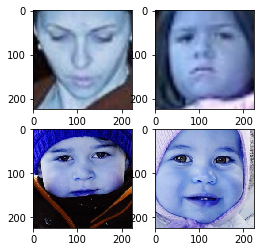

In [8]:
#Far from useless: 236 lines referred to at least one person we didn't have in our train data!
#Now we will vizualise some random photos

%matplotlib inline
import matplotlib.pyplot as plt
from random import choice, sample

#We will go for 2 pairs of images but feel free to show as much as you want
f, ax = plt.subplots(2, 2, figsize=(4, 4))
#This one is a bit tricky. If you don't understand right away, further explanation follows in the few next cells
batch = sample(data, 2)
for i, j in [(0,0), (0,1), (1,0), (1,1)]:
    #The iteration associate i with the first number from each tuple (so here 0, 0, 1, 1) and j the second (0, 1, 0, 1)
    #It allows to iterate through all the indeces possibilities in batch (which is a list of two tuples with two images)
    #Therefore, we iterate to associate each subplot to one image randomly chosen in the directory associated with the member
    #id contained in the two lines from batch
    ax[i][j].imshow(cv2.imread(choice(allPhotos[batch[i][j]])))

In [9]:
#As each line from the data dataframe contains a pair, getting a random line will get 2 images
print(batch)

[('data/recognizing-faces-in-the-wild/train/F0174/MID3', 'data/recognizing-faces-in-the-wild/train/F0174/MID7'), ('data/recognizing-faces-in-the-wild/train/F0601/MID21', 'data/recognizing-faces-in-the-wild/train/F0601/MID33')]


In [10]:
#f matches with the figure object, ax with the axes
print(f)
print(ax)

Figure(288x288)
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0c89d8438>


In [11]:
#All objects from this iteration are integers
for i, j in [(0,0), (0,1), (1,0), (1,1)]:
    print(type(i))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [12]:
#The following line allows to go through a specific family member directory through index contained in a line from batch
allPhotos[batch[1][1]]

['data/recognizing-faces-in-the-wild/train/F0601/MID33/P11958_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P12019_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P11941_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P11957_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P11961_face2.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P12017_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P12018_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P11945_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P12018_face2.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P11934_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P11965_face1.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P11943_face2.jpg',
 'data/recognizing-faces-in-the-wild/train/F0601/MID33/P06391_face22.jpg',
 'data/recognizing-faces-in-the-wild/

In [13]:
#Building a validation set. As we cannot mix up members from different families together, we can't use the good ol'
#train_test_split

train = [x for x in data if 'F09' not in x[0]]
val = [x for x in data if 'F09' in x[0]]
len(train), len(val)

(3066, 296)

In [14]:
#This method allowed us to have a 90% train 10% validation which is acceptable

def getImages(p1, p2):
    """
    Function:
    ---------
    Get a random image from allPhotos 
    
    Input:
    ------
    p1 = first path for a family member directory
    p2 = second path for a family member directory
    
    Returns:
    --------
    A random image from p1 and another from p2 in the form of arrays
    
    """
    
    p1 = read_img(choice(allPhotos[p1]))
    p2 = read_img(choice(allPhotos[p2]))
    return p1, p2


In [15]:
import numpy as np

def getMiniBatch(batch_size=16, data=train):
    """
    Input:
    ------
    batch_size = Desired batch size
    data = a dataframe with 2 features
    
    Returns:
    --------
    A list of two arrays containing arrays of images of random
    family members
    
    """
    
    p1=[]; p2=[]; Y=[]
    #Gets some pairs from data (default = 8)
    batch=sample(data, batch_size//2)
    #Iterates through pairs
    for x in batch:
        #Assigns a variable where each one takes all the photos of each
        # family member from the pair in the form of lists of arrays
        _p1, _p2 = getImages(*x)
        #Append each array to p1 and p2
        #Adds 1 to the Y list for each appended array to p1 and p2
        p1.append(_p1); p2.append(_p2); Y.append(1)
    
    #As long as the lenght of Y doesn't equals the batch_size 
    #(which will happen when all the appendings will be over
    #as there are 4 pairs of batch_size //2)
    while len(Y) < batch_size:
        #Make _p1 and p2 equal to a random family member id
        _p1, _p2 = tuple(np.random.choice(ppl, size=2, replace=False))
        #Adds a condition in case _p1 and _p2 aren't pairs
        if (_p1, _p2) not in train+val and (_p2, _p1) not in train+val:
            #Assign the value of one random image of the family member
            _p1, _p2 = getImages(_p1, _p2)
            p1.append(_p1); p2.append(_p2); Y.append(0)
        return[np.array(p1), np.array(p2)], np.array(Y)

In [16]:
from keras_vggface.vggface import VGGFace

#Setting the images dimensions, which are 224*224 in colours
IMG_DIM = (224, 224, 3)

#Then we instantiate VGGFace. Setting "include_top" to False allows to only 
#use the dimension extraction layers of the model
vggface = VGGFace(model='resnet50', include_top=False)

#VGGFace is a model with pre-trained layers, and thus is set to forbid any 
#training on its layers by default. In order to be able to train our model 
#to work specifically on our data without losing the primary advantage
#of having this already working model, we allow the last 3 layers to be 
#trained. As you will see just below, VGGFace has 174 layers, so this is a 
#really small part of the model
for layer in vggface.layers[:-3]:
    layer.trainable=True

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
len(vggface.layers)

174

In [18]:
def initialize_bias(shape, name=None):
    #This function aims to pick a given number of random sample from a 
    #gaussian distribution with positive values
    
    """
        [Copied from the original kernel]
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [19]:
def initialize_weights(shape, name=None):
    #The same function with a different center for the gaussian distribution
    #allowing positive and negative values
    """
        [Copied from the kernel]
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)


In [20]:
from keras.layers import Input, Dense, Flatten, Subtract, Dropout, Multiply
from keras.layers import Lambda, Concatenate, GlobalMaxPool2D, GlobalAvgPool2D
from keras.models import Model
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    #A simple function that returns the auc score of each "y_true"/"y_pred"
    #combination in an array
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    

In [21]:
tf.double

tf.float64

In [22]:
#We instantiate keras tensors
left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)


x1=vggface(left_input)
x2=vggface(right_input)

In [23]:
left_input

<tf.Tensor 'input_2:0' shape=(?, 224, 224, 3) dtype=float32>

In [24]:
x1

<tf.Tensor 'vggface_resnet50/avg_pool/AvgPool:0' shape=(?, 1, 1, 2048) dtype=float32>

In [25]:
#We concatenate the max value and the avg value of each tensor
x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

In [26]:
x1

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 4096) dtype=float32>

In [27]:
#We instantiate a Dense layer using random weights and bias from our
#previous functions
fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),kernel_initializer=initialize_weights,bias_initializer=initialize_bias)

In [28]:
#We apply this layer to our two tensors
x1=fc(x1)
x2=fc(x2)

In [29]:
x1

<tf.Tensor 'dense_1/Relu:0' shape=(?, 100) dtype=float32>

In [30]:
#The point of the following steps will be to get a variable containing
#|h1-h2|^2 + h1*h2
#First, we put the absolute value of the difference of the two tensors in a 
#variable
x3 = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([x1, x2])

In [31]:
x3

<tf.Tensor 'lambda_1/Abs:0' shape=(?, 100) dtype=float32>

In [32]:
#We do the same but squared
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

In [33]:
#We multiply the two tensors in a variable
x5 = Multiply()([x1, x2])

In [34]:
#We concatenate x4 and x5 wich is equivalent to doing |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

In [35]:
x

<tf.Tensor 'concatenate_3/concat:0' shape=(?, 200) dtype=float32>

In [36]:
#We then apply a Dense layer to this last variable similar to the previous one
x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)

In [37]:
x

<tf.Tensor 'dense_2/Relu:0' shape=(?, 100) dtype=float32>

In [38]:
#In order to avoid overfitting, we add a Dropout to the tensor
x = Dropout(0.2)(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [39]:
#We then pass it through a last Dense layer which will return a categorial 
#value
prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

In [40]:
#Instantiating a Siamese Neural network
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

In [41]:
#From the original kernel : ""https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24""

In [42]:
#Instantiating the siamese NN
optimizer = Adam(1e-5)
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy',auc])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [43]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import threading

In [44]:
#We instantiate a function that reduces the learning-rate when the auc will
#stop increasing
reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max', patience=6, factor=0.1, verbose=1)

In [45]:
#We instantiate a function that saves the epochs, in case of conflict, will
#save the best one in terms of auc score
model_checkpoint = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, save_weights_only=True, monitor='valu_auc', mode='max', verbose=1)

In [46]:
#We instantiate a function that will stop training when the auc score will
#stop progressing
early_stopping = EarlyStopping(monitor='val_auc', patience=15, mode='max')

In [47]:
#We setup the callbacks that will get us informed of the scores progression
#during the training
callbacks_list = [reducelr, model_checkpoint, early_stopping]

In [48]:
#We define a generator that will get all the arrays from the getMiniBatch
#function we defined earlier
def Generator(batch_size, data ):
    while True:
        yield getMiniBatch(batch_size=batch_size, data=data)

In [49]:
#We define the generator to generate through the train or the validation set
train_gen = Generator(batch_size=16,data=train)
val_gen = Generator(batch_size=16,data=val)

In [50]:
val_gen

<generator object Generator at 0x7ff085ffc750>

In [51]:
#We then use the fit_generator with the siamese_net in order to fit our
#two generators. I had to highly reduce some parameters drastically compared to the original
#kernel so my computer wouldn't explode
history = siamese_net.fit_generator(train_gen, samples_per_epoch=20, epochs=5, 
                          validation_data=val_gen, validation_steps=25, use_multiprocessing=True,
                          verbose=1,callbacks=callbacks_list,workers=4)

Instructions for updating:
Use tf.cast instead.


/home/florent/bin/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=5, validation_data=<generator..., validation_steps=25, use_multiprocessing=True, verbose=1, callbacks=[<keras.ca..., workers=4, steps_per_epoch=20)`
  


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5


/home/florent/bin/anaconda/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


20/20 [==============================] - 334s 17s/step - loss: 0.5317 - acc: 0.7889 - auc: 0.5125 - val_loss: 0.3186 - val_acc: 0.9111 - val_auc: 0.7700


/home/florent/bin/anaconda/lib/python3.7/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with valu_auc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/5
20/20 [==============================] - 320s 16s/step - loss: 0.4382 - acc: 0.8889 - auc: 0.3750 - val_loss: 0.3475 - val_acc: 0.8889 - val_auc: 0.7350
Epoch 3/5
20/20 [==============================] - 320s 16s/step - loss: 0.3816 - acc: 0.8889 - auc: 0.6188 - val_loss: 0.3897 - val_acc: 0.8889 - val_auc: 0.6050
Epoch 4/5
20/20 [==============================] - 319s 16s/step - loss: 0.4486 - acc: 0.8889 - auc: 0.4000 - val_loss: 0.4123 - val_acc: 0.8889 - val_auc: 0.5200
Epoch 5/5
20/20 [==============================] - 319s 16s/step - loss: 0.4031 - acc: 0.8889 - auc: 0.5687 - val_loss: 0.4226 - val_acc: 0.8889 - val_auc: 0.4150


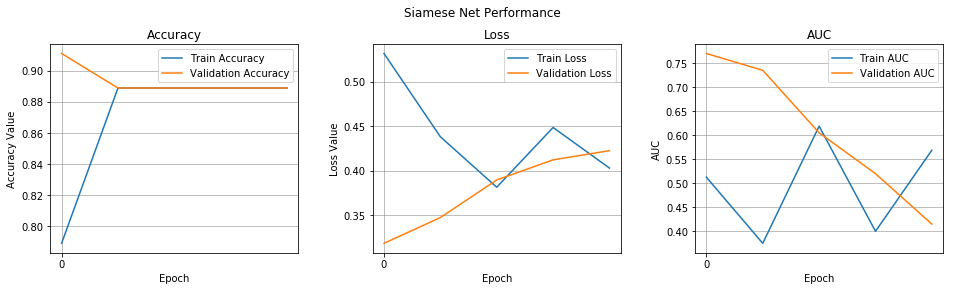

In [55]:
#Plotting the results. Most of the steps are self-explaining, so I will only 
#explain the less obvious ones
f, (ax1, ax2, ax3)=plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Siamese Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
#We make a list corresponding to the number of epoch 
epoch_list = history.epoch

ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history.history['auc'], label='Train AUC')
ax3.plot(epoch_list, history.history['val_auc'], label='Validation AUC')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('AUC');ax3.set_xlabel('Epoch');ax3.set_title('AUC')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

As we can see with these plots it would have been better to let the model longer but I technically couldn't. See the original kernel for better results

In [57]:
#There we will take the weights from the the best epoch

siamese_net.load_weights('model_best_checkpoint.h5')

In [83]:
#And finally we want to submit for the kaggle challenge
#To do so, we will use the sample submission csv

submission = pd.read_csv('/home/florent/code/SMILE_face_recognition/data/recognizing-faces-in-the-wild/sample_submission.csv')
submission['p1'] = submission.img_pair.apply(lambda x: '/home/florent/code/SMILE_face_recognition/data/recognizing-faces-in-the-wild/test/'+x.split('-')[0])
submission['p2'] = submission.img_pair.apply(lambda x: '/home/florent/code/SMILE_face_recognition/data/recognizing-faces-in-the-wild/test/'+x.split('-')[1])
print(submission.shape)
submission.head()

(5310, 4)


,img_pair,is_related,p1,p2
0,face05508.jpg-face01210.jpg,0,/home/florent/code/SMILE_face_recognition/data...,/home/florent/code/SMILE_face_recognition/data...
1,face05750.jpg-face00898.jpg,0,/home/florent/code/SMILE_face_recognition/data...,/home/florent/code/SMILE_face_recognition/data...
2,face05820.jpg-face03938.jpg,0,/home/florent/code/SMILE_face_recognition/data...,/home/florent/code/SMILE_face_recognition/data...
3,face02104.jpg-face01172.jpg,0,/home/florent/code/SMILE_face_recognition/data...,/home/florent/code/SMILE_face_recognition/data...
4,face02428.jpg-face05611.jpg,0,/home/florent/code/SMILE_face_recognition/data...,/home/florent/code/SMILE_face_recognition/data...


In [84]:
submission.iloc[0, 3]

'/home/florent/code/SMILE_face_recognition/data/recognizing-faces-in-the-wild/test/face01210.jpg'

In [87]:
from tqdm import tqdm
probs = []
#tqdm is used to have a pretty indicator to watch the progress of an iteration
#In the following iteration, we will compute the test predictions
for i, j in tqdm([(0,250), (250, 500), (500,750), (750, 1000), (1000,1250), (1250, 1500), (1500, 1750), (1750,2000), (2000,2250),(2250,2500), (2500,2750),(2750,3000), (3000, 3250), (3250, 3500), (3500,3750), (3750, 4000), (4000,4250), (4250, 4500), (4500,4750), (4750, 5000), (5000,5310)]):
    #We create list of arrays of index i:j from the paths in the p1 
    #variable of sample_submission 
    imgs1 = np.array([read_img(photo) for photo in submission.p1.values[i:j]])
    #Same with p2
    imgs2 = np.array([read_img(photo) for photo in submission.p2.values[i:j]])
    prob =  siamese_net.predict([imgs1, imgs2])
    #We squeeze them in order to append them later to the csv
    probs.append(np.squeeze(prob))
    #Then we clear the imgs1 and imgs2 list so we can use them for the next
    #iteration
    del imgs1, imgs2; gc.collect()



  0%|          | 0/21 [00:00<?, ?it/s]

MemoryError: 